# Kraken 2 taxanomic annotation 

Kraken 2 is a taxonomic classification system that uses short genomic substrings (k-mer) matches. The k-mer is matched within a query sequence with the lowest common ancestor of all genomes containing the exact k-mer. Kraken is fast and provides a taxa report for each sample. To read more about Kraken2 and install the tool visit github.com/DerrickWood/kraken2/wiki. 

This script will align reads against the kraken database to find the taxa. In this case, I am using sediment metagenome data sampled from hydrocarbon seepages in the Gulf of Mexico and identifying taxa families. Taxa identification is necessary to find species richness later for the rarefaction curve. Rarefaction curves are described later, after the taxa is identified and generated into a .csv table. 

** Installing Kraken 2 locally **

Documentation available here: 
- Kraken 2 GitHub https://github.com/DerrickWood/kraken2/wiki
- Installing and Running Kraken 2 https://blogs.iu.edu/ncgas/2019/09/24/taxa-annotation-for-shotgun-sequenced-metagenomic-data/

** Input data **

Metagenomic datasets. In this case the metagenomes were downloaded from NCBI's Sequence Read Archive (SRA) under the BioProject number PRJNA553005. There are seven sediment metagenomes under this BioProject.

** Running Kraken 2 command ** 

`kraken2 --db $KRAKEN_DB --use-names --report-zero-counts --paired "$f"_1.fq "$f"_2.fq --report "$f"_kraken_report`

Looking at the command above, the input samples are the forward and reverse read of the sample. Only one sample can be ran at a time using this command. In this case we had seven samples, so the command was run seven times. 

** Results from Kraken 2 **

This command will generate a report with the specified parameters (use-names, report-zero-counts, paired) for the sample as output. More information about Kraken 2 parameters and output are described in the manual. 

Since every output is in a separate table, we need to combine them to make a rarefaction curve later. To prepare for this step, all kraken reports should be placed in thier own directory.

## Generating one output table for all the samples
Since the kraken reports currently are generated for each sample, we will need to generate one output csv or tsv table that has the taxanomic abundances for all the samples. The resulting table will be provides as input for the different visualization tools described in this notebook. 

** Download the python3 script from GitHub **

`git clone https://github.com/npbhavya/Kraken2-output-manipulation.git`

** Place all the Kraken 2 reports to one directory **

`mkdir kraken_report` 

`mv *_kraken_report FILEPATH/kraken_report/`

** Run the command **

`python kraken-multiple-taxa.py -d kraken_report/ -r F -c 1 -o kraken-report-final`

** Result explained ** 

The following command is used to get taxa information instead of taxa ID. The input -d for script the directory of kraken reports for each sample. 
-r defines taxonomic rank: (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies
-c defines the column to be included in the final report col1: number of reads covered; col2: percentage of reads covered by taxa
-o output, defines output file name

The output is a table of taxa families followed by numbers that will look something like:

        Taxa    ['sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6', 'sample7']
        Pseudomonadaceae        ['78249', '103170', '81428', '76970', '75855', '69162', '92573']
        Moraxellaceae   ['9420', '6299', '10383', '10311', '6685', '3269', '9622']
        Enterobacteriaceae      ['31660', '27116', '34082', '31873', '24965', '16778', '33615']

This step was run again using a different ranks (phylum, genus, and species) and using percentages.

** Converting the table to csv **

`sed -e "s/\[//g;s/\]//g;s/'//g;s|\t|,|g" kraken-report-final >kraken_report_final_taxa_table.csv`

The output for the csv file command should look like a table. This table is now ready to be imported to use in R scripts below. 

## Jetstream

Jetstream is a cloud computing resource that provides access to pre-configured virtual machines (VM) with root access. Using VM’s helps with the transition of non-computer science background professionals to the command line, software installs and onto running analysis on LINUX environment (as most HPC clusters). For more on Jetstream, go to https://kb.iu.edu/d/bfde. For getting started on Jetstream, go to https://blogs.iu.edu/ncgas/2017/10/18/getting-started-on-jetstream/

** Setting up Jupyter notebook on Jetstream instance ** 

A medium Ubuntu 18.04 instance was launched and Jupyter notebooks was installed following https://blogs.iu.edu/ncgas/2020/06/15/installing-jupyter-notebook-on-jetstream/. Select a instance size depending on your dataset. In additon, a 100 GB volume was attached. Request a larger volume if needed. The final kraken report in .csv format was transferred to the volume. 
***

# Jupyter notebook

The below steps onwards the scripts and commands can be run on Jupyter notebooks. 


## Rarefraction curve 

** Introduction **

A rarefaction curve shows species richness of a sample to determine if a sample is representative of a larger population by plotting the sample size and species. A rarefaction curve showing a respresentative sample will grow rapidly and then slowly plateau. The rapid growth shows how every read in the sample identifies as a new organism and the plateau shows the rare species in the sample that remain to be sampled. If your samples do not reach a plateau, it is suggested that most species in the sample are rare; Increasing the sample size will create a better respresentation of the larger population. 

In regard to our data, we are making a rarefaction curve to determine if the sediment metagenome samples are respresentative of the microbial community in the Gulf of Mexico.

Before plotting a rarefaction curve, it is necessary to identify taxa using Kraken2 or another taxa identification tool because this information is neccessary to calculate species richness. The .csv table generated from the kraken reports will be used. The input for the table will be read as a table, but then transposed and read as a data frame for the rarefaction curve.

** Installations **

- vegan

** Input files ** 

Generated "**kraken_report_final_taxa_table.csv**" table


In [1]:
#Installation of the packages if they aren't already downloaded
install.packages("vegan");

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘permute’




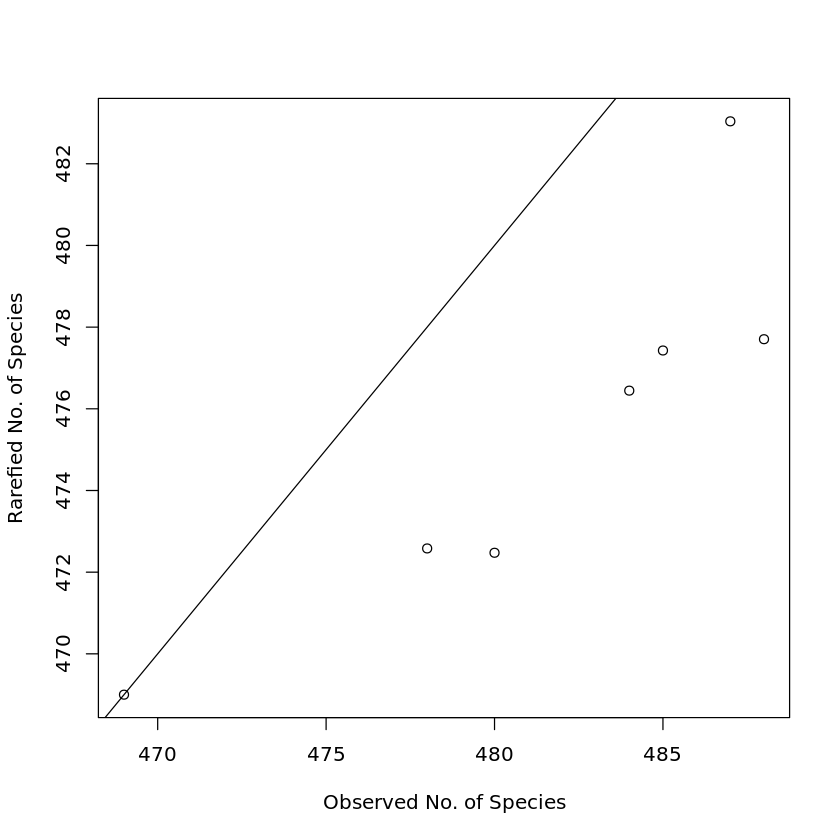

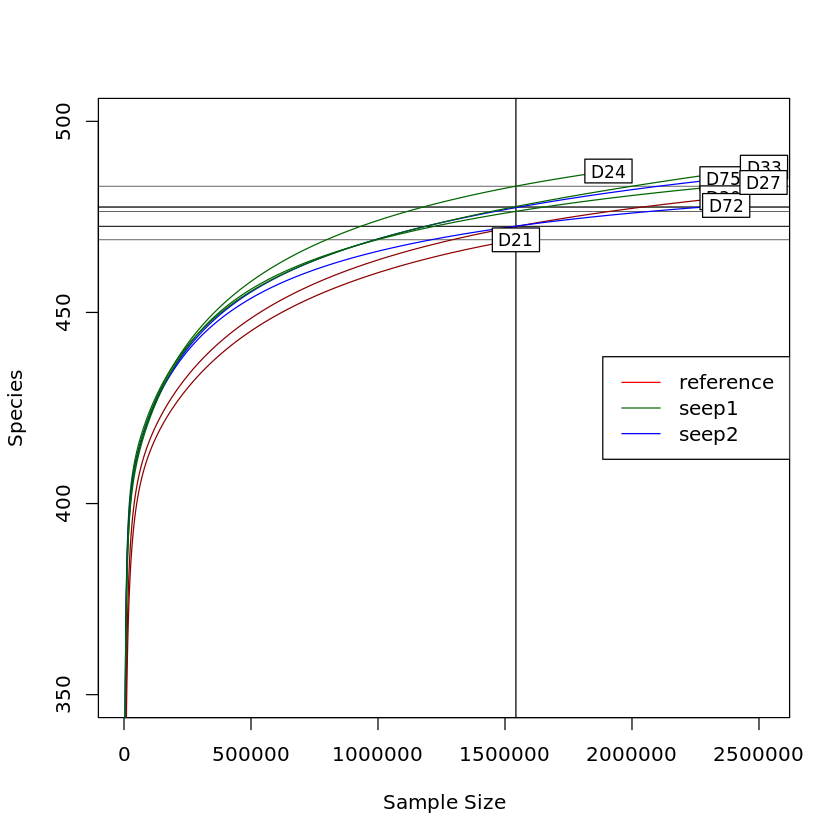

In [3]:
library(vegan);

#importing the file and parsing the file correctly
#Replace the kraken.csv name to the actual filename.
Data=read.table("kraken_report_final_taxa_table.csv", sep=",", row.names = 1, header=TRUE);

#replacing long file names with shorter ones
colnames(Data)[1:7] = c("D75","D30","D33","D72","D24","D21","D27")

Data_t=as.data.frame(t(Data));

#count the number of species
S = specnumber(Data_t);
raremax = min(rowSums(Data_t));
#print(raremax);

#Rarefaction of the samples
Srare = rarefy(Data_t, raremax);
#print(Srare);

#plotting the rarefaction curves
plot(S, Srare, xlab = "Observed No. of Species", ylab = "Rarefied No. of Species")
abline(0, 1)
rarecurve(Data_t, step =20, sample = raremax, 
          col = c("blue", "darkred", "darkgreen", "blue", "darkgreen", "darkred", "darkgreen"), 
          cex = 0.85, ylim=c(350,500))
legend("right", legend=c("reference", "seep1", "seep2"),
       col=c("red", "darkgreen","blue"), lty=1, cex=1, text.font=1)

** Graph explained **

Looking at the rarefaction curve calculated using the metagenome samples from the Gulf of Mexico above, the curve grows rapidly and then plateaus. *The y-axis starts at 350, so the actual increase of the samples is more dramatic than shown in the graph currently.* The plateau in the graph shows that no new species are being identified in the samples.  

In the plot, we can see that D21 (ref) stops short of the other samples, which means that there are less rare species in D24 compared to other samples. Similarly, D24 (transition seep 1) stops in between D21 and other samples, which shows that D24 has less rare species than other samples, but more than D21. Meanwhiles, D72, D75, D30, D27, and D33 are similar in number of species relative to the sample size.

This graph shows that the seven samples taken is a representative sample of the larger population of microbes in the Gulf of Mexico. A non-representative sample would not reach a plateau, if this happens you may need to add more samples to your data set.

** Extra information about rarefaction plots **

I changed the scale of the plot using `ylim=c(350, 500)` because the increase was sustained on the majority of the graph making the sample curves hard to analyze. To get a better view and zoom in, I changed the y axis in the `rarecurve()` function. You can also change the x axis using this argument as well, changing `ylim=c(0,0)` to `xlim`.

How to draw rarefaction curves with custom colors 
- https://fromthebottomoftheheap.net/2015/04/16/drawing-rarefaction-curves-with-custom-colours/

## Ordination plots

Deciding which ordination plot to use is dependent on the type of data you have and what you are trying to visualize. Here we are plotting three ordination plots, Principal Component Analysis (PCA), non-metric Multidimensional Scaling (nMDS), and Principal Coordinate Analysis (PCoA). 

## PCA plots

** Introduction ** 

A principal component analysis (PCA) is a type of ordination plot. Ordination plots summarize data by reducing the dimensions, or variables, and plotting the samples in a format that can be visualized. A PCA plot shows the direction of maximal variation between multiple variables by condensing them into new variables, called principal components, in a data set without compromising information. A PCA plot reduces the dimensions of a matrix to show how similar or dissimilar samples are based on their distance and grouping of each other. 

For more information on ordination plots, https://ncgas.org/training/r-for-biologists-workshop.html. 

** Installations ** 

- devtools
- ggbiplot

***For R 3.4.4 (unnecessary if R 4.0.2 is installed)***

In preparation to make an ordination plot using **devtools**, several dependency packages also must installed. On the version of R (3.4.4), the libraries for these packages are not installed. This is because it is a older version of R. The step of installing dependecy libraries in the terminal with file path to the library is neccessary or devtools will not install properly and the script won't work.

_Requirements_
- R v3.4.4
- curl libraries 
- ssl libraries 
- xml2 libraries

Download the below libraries to the instance in case they are not already installed,

    sudo apt-get install -y libcurl4-openssl-dev
    sudo apt-get install libssl-dev
    sudo apt-get install libxml2-dev 

In [8]:
#Installation of the packages if they aren't already downloaded for plotting PCA 

#install.packages("gh");
#install.packages("usethis");
#install.packages("covr");
#install.packages("roxygen2");
#install.packages("rversions");
#install.packages("devtools");
#library(devtools)
#install_github("vqv/ggbiplot") 

Skipping install of 'ggbiplot' from a github remote, the SHA1 (7325e880) has not changed since last install.
  Use `force = TRUE` to force installation



** Below is the code to plot the PCA plot for the metagenomic datasets from the "kraken_report_final_table.csv" table **

After installing the correct packages, dependencies, and libraries, this script was used to make the PCA. 

Importance of components:
                             PC1       PC2       PC3       PC4       PC5
Standard deviation     4.464e+04 6.430e+03 3.039e+03 1.459e+03 514.90541
Proportion of Variance 9.741e-01 2.021e-02 4.510e-03 1.040e-03   0.00013
Cumulative Proportion  9.741e-01 9.943e-01 9.988e-01 9.999e-01   0.99999
                             PC6      PC7
Standard deviation     118.48587 2.21e-13
Proportion of Variance   0.00001 0.00e+00
Cumulative Proportion    1.00000 1.00e+00

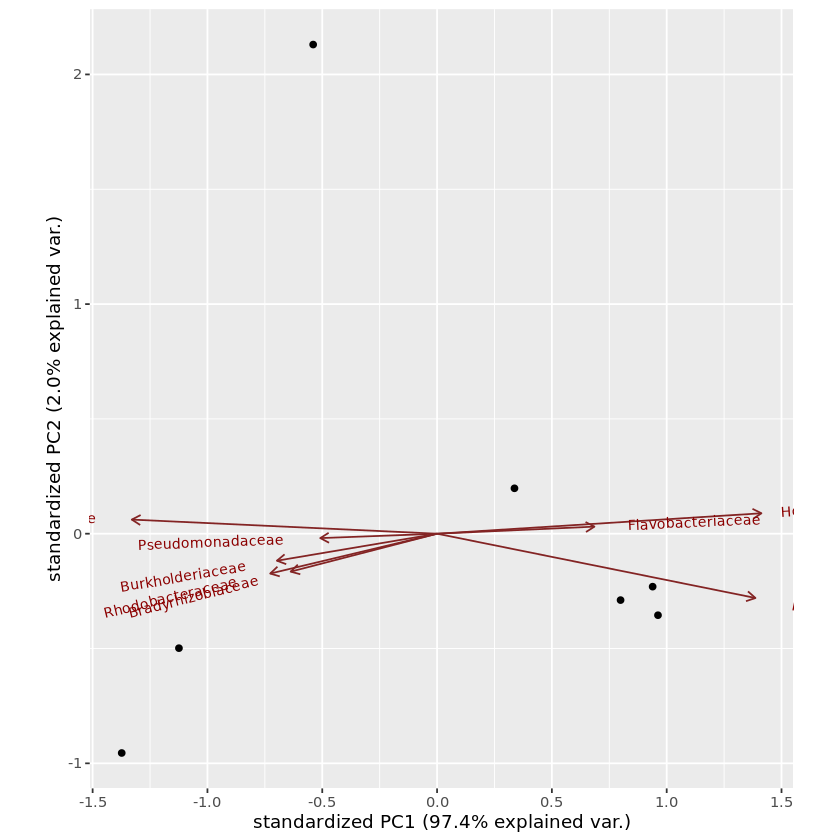

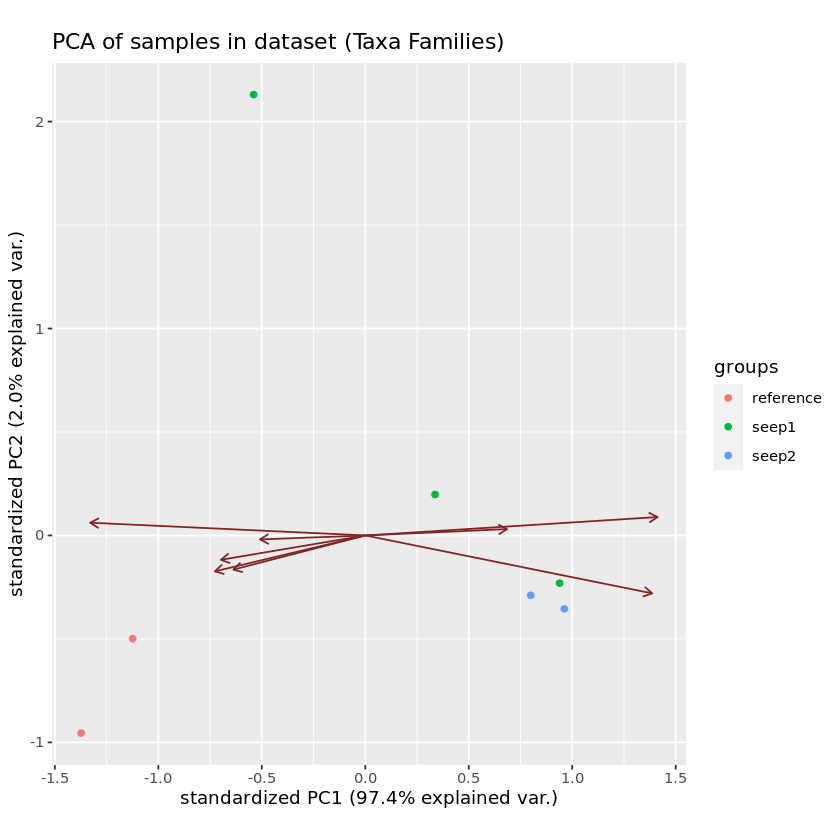

In [11]:
library(devtools)
library(ggbiplot)

#normalizing the data using raremax but slightly differently than done previously
Data_t=as.data.frame(t(Data))

raremax <-min(rowSums(Data_t))
Srare <- rrarefy(Data_t, raremax)
Srare=as.data.frame(Srare)

#step to remove the variables without a lot of variance
#removes columns with sums
Srare_clean = Srare[, colSums(Srare > 40000) > 0]

#computing the principal coordinates
data.pca=prcomp(Srare_clean, center = TRUE)
summary(data.pca)

#PCA plots  
ggbiplot(data.pca)
location=c("seep2","reference","seep1","seep2","seep1","reference","seep1")
p1 = ggbiplot(data.pca, varname.size = 0, varname.adjust = .02, ellipse = FALSE, 
         groups = location) +
ggtitle("PCA of samples in dataset (Taxa Families)") +
theme_gray() +
theme(legend.position = "right")

print(p1)

** Conclusions from this graph **

Looking at the plot above, we see that there are five taxa families (Streptomycetaceae, Pseudomonadaceae, Burkholderiaceae, Rhodobaceraceae, Bradyrhizobiaceae) are more correlated with reference samples while three families (Hominidae, Methanosarcinaceae, Flavobacteriaceae) are more correlated with seeps. These taxa families were labeled after saving the plot because a couple of the names wrote off the plot and were unreadable. Adding labels after on Powerpoint or another program will help ensure clarity when reading the plot. 

This plot shows that Seep 2 samples are clustered together which means that they are more correlated compared to the other samples. Similarly, the reference samples are cluster together showing their correlation compared to other samples. Lastly, seep 1 sample (D24) seems uncorrelated because it does not cluster near the reference or seep samples and is plotted far and above all the samples. 

## non-metric Multidimensionality Scaling (nMDS)

This is another ordination plot that visualizes the data based on the similarity distance. In this method, similarity distance can be calculated using different methods, Euclidean, Bray Curtis, Jaccard etc.   

** Introduction **

MDS plots maps the position of the samples with n dimensions, by calculating a proximity matrix. The farther the samples are from each other, the more different they are. 

** Installation ** 
- vegan package (should be already installed if you ran rarefaction curves section)

** Input data ** 

Normalized data. 
In this case it is the the kraken family level abundances that was normalized based on species richness using the rrarefy function 

Run 0 stress 9.079523e-05 
Run 1 stress 9.128065e-05 
... Procrustes: rmse 0.1202341  max resid 0.1987572 
Run 2 stress 0 
... New best solution
... Procrustes: rmse 0.1231658  max resid 0.1724754 
Run 3 stress 9.278719e-05 
... Procrustes: rmse 0.117512  max resid 0.1790104 
Run 4 stress 7.242834e-05 
... Procrustes: rmse 0.1347738  max resid 0.1797545 
Run 5 stress 9.341927e-05 
... Procrustes: rmse 0.09825299  max resid 0.1260512 
Run 6 stress 8.38468e-05 
... Procrustes: rmse 0.1532942  max resid 0.234159 
Run 7 stress 0.1456737 
Run 8 stress 2.433703e-05 
... Procrustes: rmse 0.08596975  max resid 0.1446037 
Run 9 stress 3.957524e-05 
... Procrustes: rmse 0.1692674  max resid 0.2313071 
Run 10 stress 5.955782e-05 
... Procrustes: rmse 0.1627712  max resid 0.2793522 
Run 11 stress 9.402723e-05 
... Procrustes: rmse 0.1584353  max resid 0.2456775 
Run 12 stress 0 
... Procrustes: rmse 0.1338084  max resid 0.2377572 
Run 13 stress 0.1838287 
Run 14 stress 4.573069e-05 
... Procrustes

Warning message in metaMDS(d, distance = "jaccard", k = 3):
“stress is (nearly) zero: you may have insufficient data”


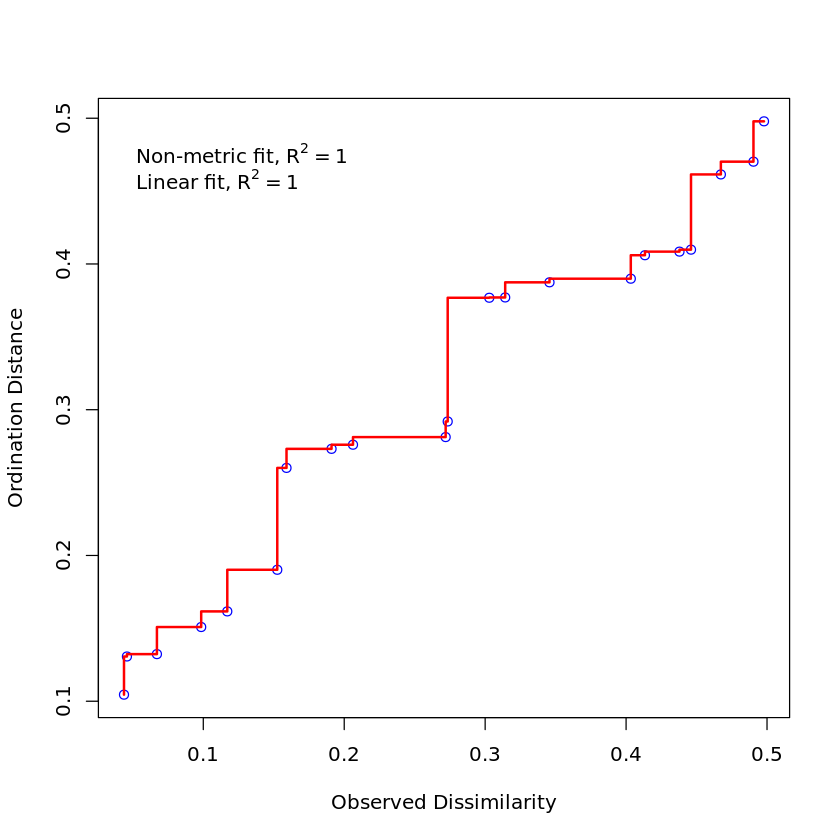

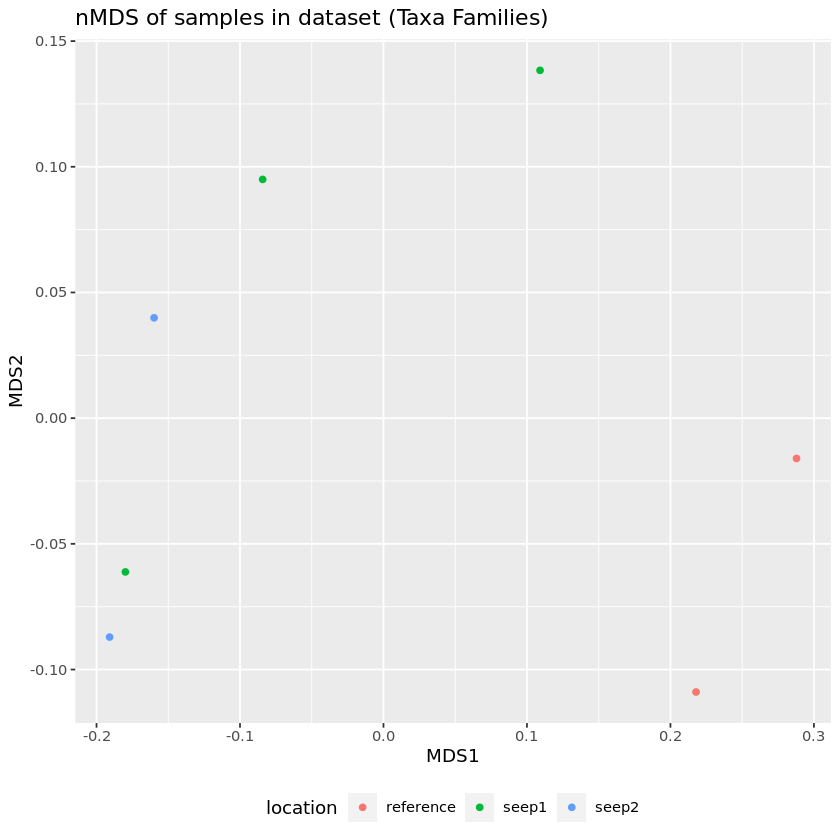

In [5]:
library(vegan)
library(ggbiplot)

d=vegdist(Srare, method="jaccard")
d_matrix=as.matrix(d, labels=T)
mds=metaMDS(d, distance = "jaccard", k=3) #k=number of dimensions
mds_data=as.data.frame(mds$points)
mds_data$SampleID =rownames(mds_data)

#one way to visaluze the MDS plots 
p2 = ggplot(mds_data, aes(x=MDS1, y=MDS2, color= location)) +geom_point() +
ggtitle("nMDS of samples in dataset (Taxa Families)") +
theme_gray() +
theme(legend.position = "bottom")
stressplot(mds)
print(p2)

** Conclusions from the graph **

From this graph we can determine that the two reference samples are very similar to each other as they are placed close to each other in the graph. Similarly, there are more differences within the seep samples, especially the seep 1 samples that cluster really far away from each other. In order to further gain more confidence on the representation, we can look at the goodness of fit value that determines the differences between the actual distances and predicted values. 

The shepard plot(first plot above) shows how the data scatter around the line. Large scatter around the line suggests original dissimilarities are not preserved. In this case, the data points are all on the line suggesting that the data fit the model. 

Blog that explains nMDS in little more detail https://jonlefcheck.net/2012/10/24/nmds-tutorial-in-r/

## Prinicpal Coordinate Analysis (PCoA)

** Introduction **

This is another ordination plot that allows for metric dimensional scaling attempting to represent dimilarity and dissimilarity in a low dimensional space. Unlike PCA, for this analysis the input is the dis-similarity or the similarity matrix as input. However, when the distance is calculated using euclidean distance, the PCoA is equivalent to PCA. While the input for the PCoA is also a similarity matrix like nMDS, the two methods differ in their algorithm and properties. 

** Input data ** 

distance matrix from the above MDS calculation from above. 
The beta diversity index is calculated from the input data to calculate the PCoA analysis.



	Homogeneity of multivariate dispersions

Call: betadisper(d = d, group = location)

No. of Positive Eigenvalues: 6
No. of Negative Eigenvalues: 0

Average distance to median:
reference     seep1     seep2 
  0.04926   0.11450   0.03355 

Eigenvalues for PCoA axes:
    PCoA1     PCoA2     PCoA3     PCoA4     PCoA5     PCoA6 
0.2653942 0.0193905 0.0039759 0.0023419 0.0013586 0.0002727 


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,2,0.009406254,0.004703127,0.9218745,0.4685294
Residuals,4,0.020406798,0.005101699,NA,NA


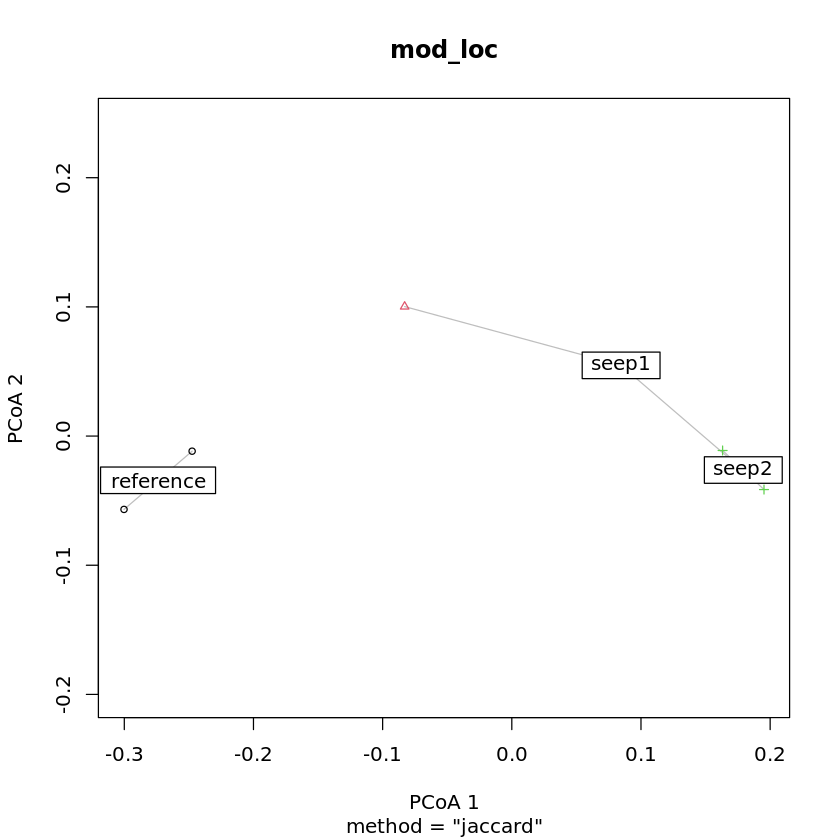

In [10]:
## Beta diversity index and PcoA plots 
## Calculate multivariate dispersions
mod_loc <- betadisper(d, location)

print(mod_loc)
#Statistical test 
anova(mod_loc)


#Plot the groups and distances to centroids on the with data ellipses instead of hulls - PCoA plots 
plot(mod_loc, ellipse = FALSE, hull = FALSE, conf = 0.90) # 90% data ellipse

** Conclusions from the graph **

From this graph we can determine that the two reference samples are very similar to each other as they are placed close to each other in the graph. Similarly, there are more differences within the seep samples but they cluster together.  


### Ordination plots conclusions 

In the three ordination plots that were made, the samples taken in the same locations cluster towards each other. This shows that although the plots use different measures, the data is displayed the same and the groupings are evident across different measurement methods in the plots. There are more detailed explainations under each plot.

***
**Some ways to save plots in Jupyter Notebook**

- as jpg

    `jpeg("rplot.jpg", width = 500, height = 500) #making jpg`
    
    `plot(mod_loc, ellipse = FALSE, hull = FALSE, conf = 0.90) # PCoA plot`
    
    `dev.off()`


- right click on graph/plot
    - "Save image as"

** Plot in one figure **

I tried this and you can view it below, but it doesnt work for PCoA beause I couldnt save the plot function like PCA and nMDS. This could be used to plot multiple PCAs or something else. 

    library(gridExtra)
    grid.arrange(p1,p2, ncol=2)

** Other Resources ** 

- https://www.statmethods.net/advgraphs/layout.html 
- https://cran.r-project.org/web/packages/egg/vignettes/Ecosystem.html 


Below is two attempts using the above resources to plot the ordination figures into one graph. This did not exactly work out like I planned, but this information may be useful for some people which is why I am including it :) 

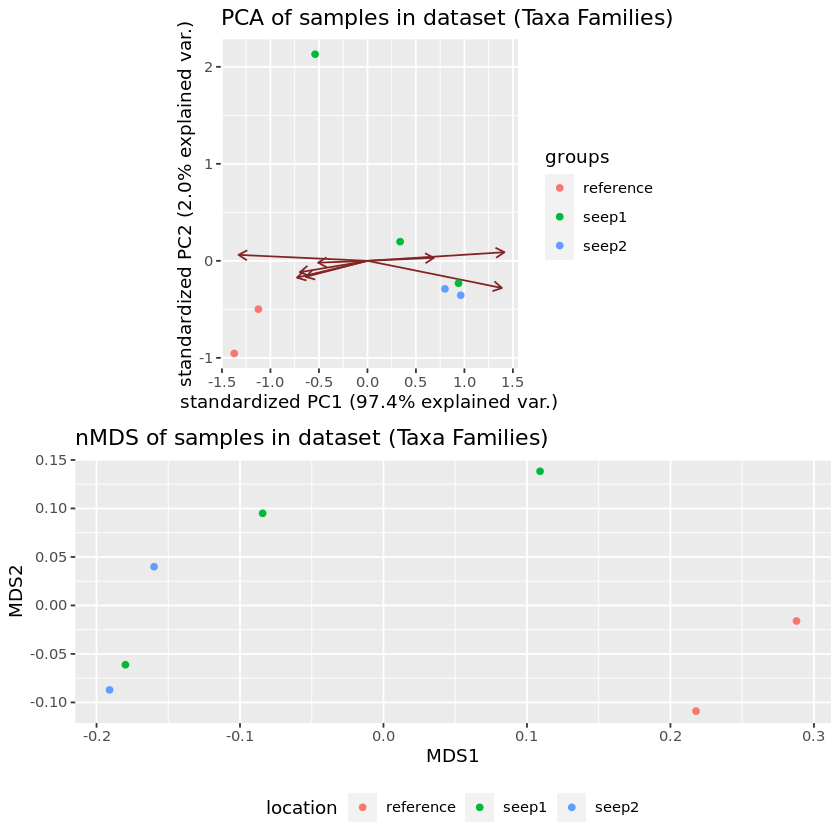

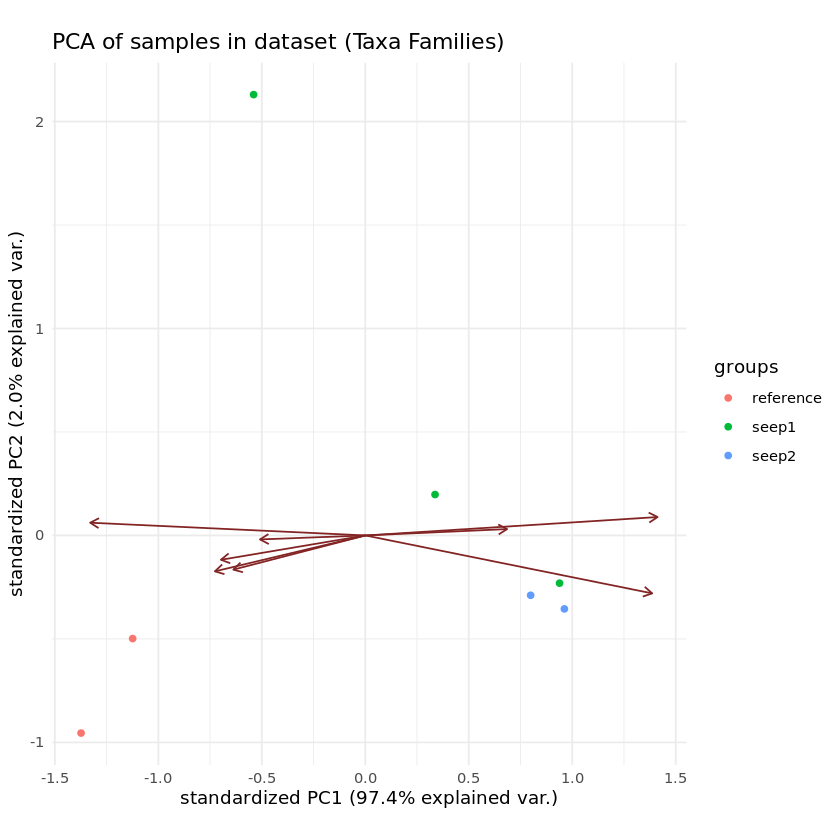

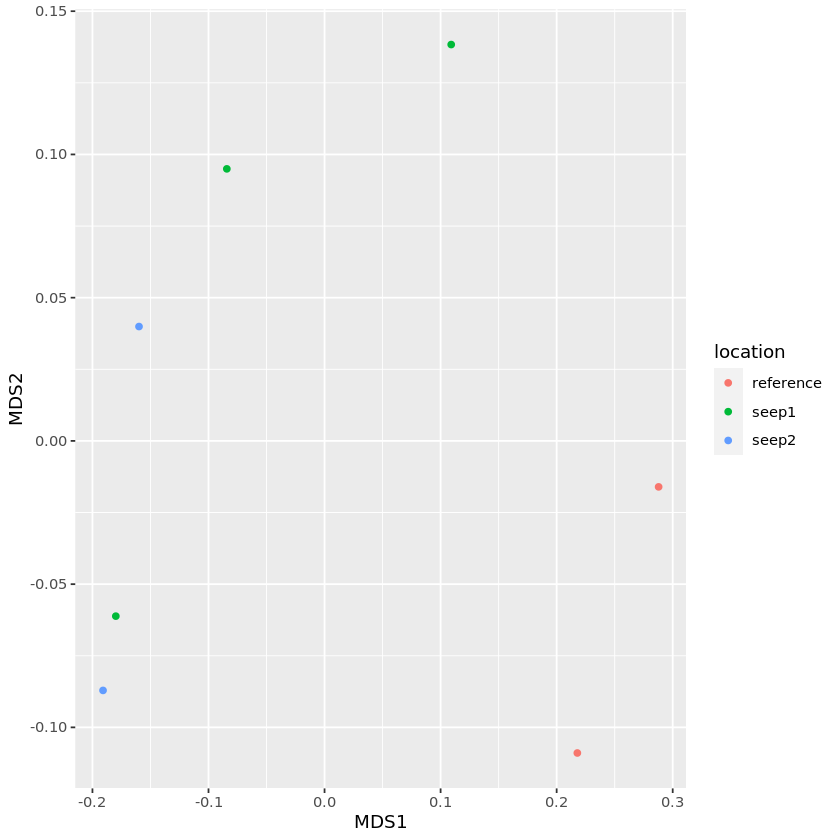

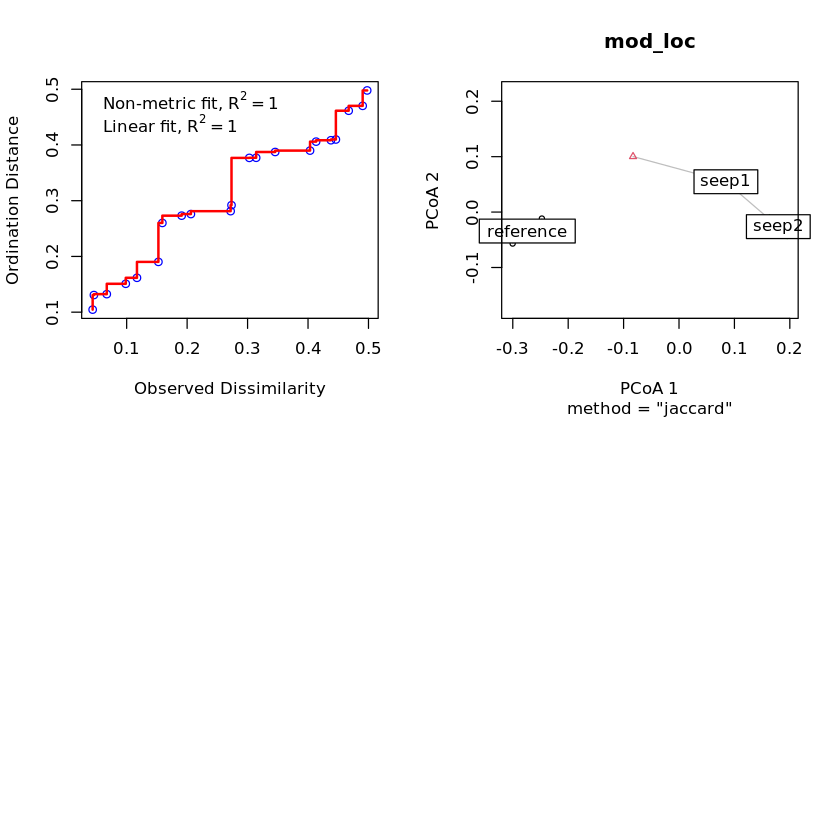

In [12]:
#combining ordination plots into one figure
#doesnt work for PCoA so i screenshotted and added labels and whatever in powerpoint

library(gridExtra)
grid.arrange(p1,p2, ncol=1)

#second way to combine plots into one figure
old.par <- par(mfrow=c(2, 2))
#pca plot
ggbiplot(data.pca, varname.size = 0, varname.adjust = 0, ellipse = FALSE, 
         groups = location) +
ggtitle("PCA of samples in dataset (Taxa Families)") +
theme_minimal() +
theme(legend.position = "right")
#nMDS plot
ggplot(mds_data, aes(x=MDS1, y=MDS2, color= location)) +geom_point()
stressplot(mds)
#pcoa plot
plot(mod_loc, ellipse = FALSE, hull = FALSE, conf = 0.90)
par(old.par)

#### ggplot features and themes

On my PCA plot, I decided to not add variable names to the eigenvectors (arrows) because the taxa family names were reading off the plot. To change the variable names and position I suggest seeing ggbiplot documentation to add labels and adjust size and placement ``varname.size = 3, varname.adjust = 1``. For me, I was able to move the variable names just enough to know what they were so I could label them after I saved my plot. This was easier/faster for me which is why I chose to do it in this way, but there seems to be ways to do this within R. 

I also changed the theme of the plots so that they would match. I did this for clarity and flow. You can do this too, just google it, or click the link to learn how to change the theme of your plot!

** different `theme_ ()` changes https://ggplot2.tidyverse.org/reference/ggtheme.html **
***

## Alluvial plot

** Introduction **

An alluvial plot is similar to a sankey diagram. Alluvial plots show how sets of groups change according to differnt dimensions. In the ordination plots, one point was plotted far away from the other clusters suggesting that this sample is different from all the samples. To visualize the similiarities and dissimiliarites within the metadata of the samples, we used an alluvial plot. 

** Installation ** 
- ggaluvial package 
- ggplot2 

** Input data **

The python3 script was ran again on the kraken report directory to get taxa phylums `-r P` and percent of reads covered by taxon `-c 1`. The output of the script was converted to a .csv file as previously using `sed -e "s/\[//g;s/\]//g;s/'//g;s|\t|,|g" kraken-report-final >kraken_report_phylum_percent.csv`. 

The file was reformatted to have every variable in a column. This is necessary for the alluvial plot script. Taxa phylum with low abundance was grouped into one taxa called "Other". Other variables from the data set were added such as location, thermogenic gases detected, hydrocarbons detected, and sample names from the published paper.


The input file for this script is ** phylumreformat.csv **

In [ ]:
#Installation of the packages if they aren't already downloaded for alluvial plots 
install.packages("ggalluvial")
install.packages("ggplot2")

Loading required package: ggplot2

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message:
“The parameter `infer.label` is deprecated.
Use `aes(label = after_stat(stratum))`.”


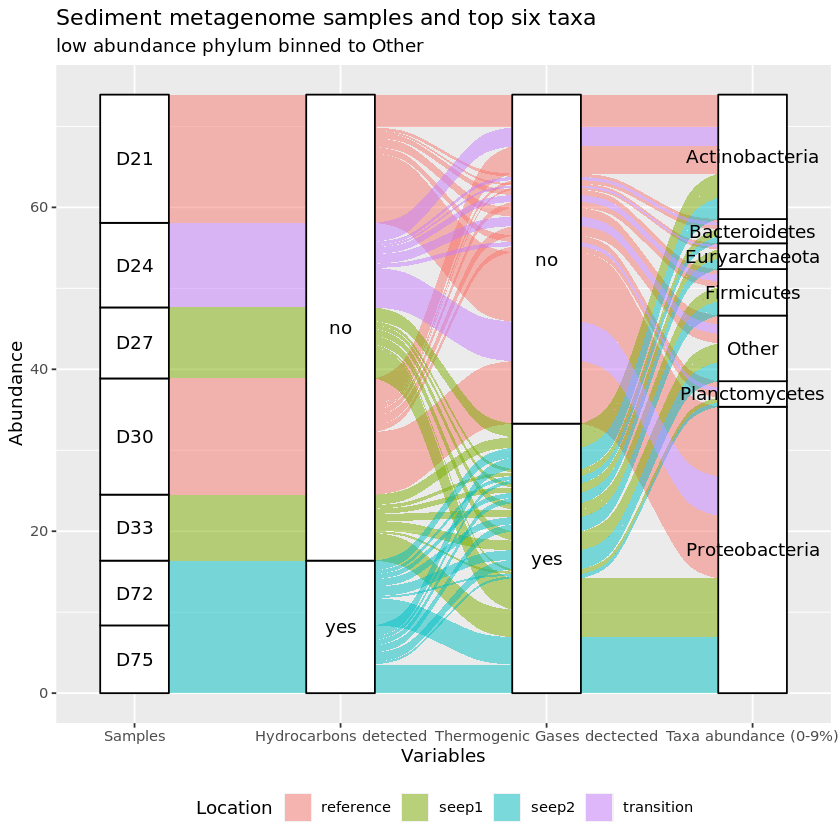

In [22]:
library(ggalluvial);
library(ggplot2);


#reformatted samples and taxa in excel to have abundances in one column to bin 
mydata=read.table("phylumreformat.csv", sep=",", header = TRUE)
#print(data)

#binnning
#not sure about open intervals; right/left=FALSE
mydata$AbundanceBin<-cut(mydata$Abundance, seq(0,9,3), right=FALSE)
#print(data)
reformat=data.frame(mydata)

#add locations/other variables to data
reformat$Location= (c("reference","reference","reference","reference","reference","reference","reference", 
                      "reference","reference","reference","reference","reference","reference","reference", 
                      "transition","transition","transition","transition","transition","transition","transition", 
                      "seep1","seep1","seep1","seep1","seep1","seep1","seep1",  
                      "seep1","seep1","seep1","seep1","seep1","seep1","seep1", 
                      "seep2","seep2","seep2","seep2","seep2","seep2","seep2", 
                      "seep2","seep2","seep2","seep2","seep2","seep2","seep2"))
reformat$ThermogenicGases= (c("no","no","no","no","no","no","no",
                              "no","no","no","no","no","no","no",
                              "no","no","no","no","no","no","no",
                              "yes","yes","yes","yes","yes","yes","yes",
                              "yes","yes","yes","yes","yes","yes","yes", 
                              "yes","yes","yes","yes","yes","yes","yes",
                              "yes","yes","yes","yes","yes","yes","yes"))
reformat$Hydrocarbons= (c("no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "yes","yes","yes","yes","yes","yes","yes",
                          "yes","yes","yes","yes","yes","yes","yes"))
reformat$Samples= (c("D21","D21","D21","D21","D21","D21","D21",
                          "D30","D30","D30","D30","D30","D30","D30",
                          "D24","D24","D24","D24","D24","D24","D24",
                          "D27","D27","D27","D27","D27","D27","D27",
                          "D33","D33","D33","D33","D33","D33","D33",
                          "D72","D72","D72","D72","D72","D72","D72",
                          "D75","D75","D75","D75","D75","D75","D75"))

#head(reformat)

ggplot(data = reformat,
       aes(axis1 = Samples, axis2 = Hydrocarbons, axis3 = ThermogenicGases, axis5 = Taxa,
           y = Abundance)) +
  scale_x_discrete(limits = c("Samples","Hydrocarbons detected","Thermogenic Gases dectected","Taxa abundance (0-9%)"), expand = c(.11, .05)) +
  xlab("Variables") +
  geom_alluvium(aes(fill = Location)) + 
  geom_stratum() + geom_text(stat = "stratum", infer.label = TRUE) + 
  theme(legend.position = "bottom") +
  ggtitle("Sediment metagenome samples and top six taxa",
          "low abundance phylum binned to Other")

** Conclusions from the graph **

From this graph we can see how the samples, grouped by location, flow through variables (Hydrocarbons detected, Thermogenic Gases detected, and Taxa abundance (0-9%)). The taxa abundance is 0-9% because the samples contain 88-90% unidentified reads. Sample D21 had the highest abundance of Proteobacteria across all samples being ~8.5%. This is why the taxa phylum with very low abundance were grouped into the catogory "Other".

Looking at this graph, the samples have highest abundance in Proteobacteria, which is why the section for Proteobacteria is larger compared to the other taxa in the column (stratum). Similarly, most abundance comes from many phylum with small abundances.  

We can also see that there is a larger abundance of Actinobacteria in reference samples.
  
The transition sample is similar to the seeps in that it has no hydrocarbons like seep 1 and the reference samples, and similar to the reference sample in that there were no thermogenic gases detected. 

** More information **


- https://corybrunson.github.io/ggalluvial/articles/order-rectangles.html#more-examples-1
- http://corybrunson.github.io/ggalluvial/reference/stat_alluvium.html
***

# Heatmaps

**Introduction**

Heatmaps are a way to summarize a table of abundances or another numerical value into a color-coded map. They can be very colorful and easy to understand. 

I made the following heatmaps from the "ComplexHeatmap" package from Bioconductor using `Heatmap()`. To obtain less variation I went back to the kraken annotation table and made .csv files for the taxonomic ranks, genus and species.

**Installations**
- ComplexHeatmap from Bioconductor
- RColorBrewer

**Input Data** 

- kraken_genus_percent_table.csv
- kraken_species_percent_table.csv

Heatmaps require a **matrix** with the taxa phylum as rows and the samples in one column. We must transform our initial taxa classification table and change it into a matrix. I put an example of a few rows and columns of how the data should look as a matrix below: 

| Taxa | Proteobacteria | Actinobacteria | Firmicutes | Cyanobacteria | Chloroflexi |
|-|-|-|-|-|-|
| **sample1** | 3.53 | 1.41 | 0.88 | 0.24 | 0.12 |
| **sample2** | 7.72 | 3.37 | 0.73 | 0.18 | 0.11 |
| **sample3** | 3.41 | 1.29 | 0.90 | 0.25 | 0.12 |

- https://www.tablesgenerator.com/markdown_tables

Heatmaps should use normalized data, like percents, to lower bias. Below is the script for a heatmap.

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("ComplexHeatmap")

install.packages("RColorBrewer")

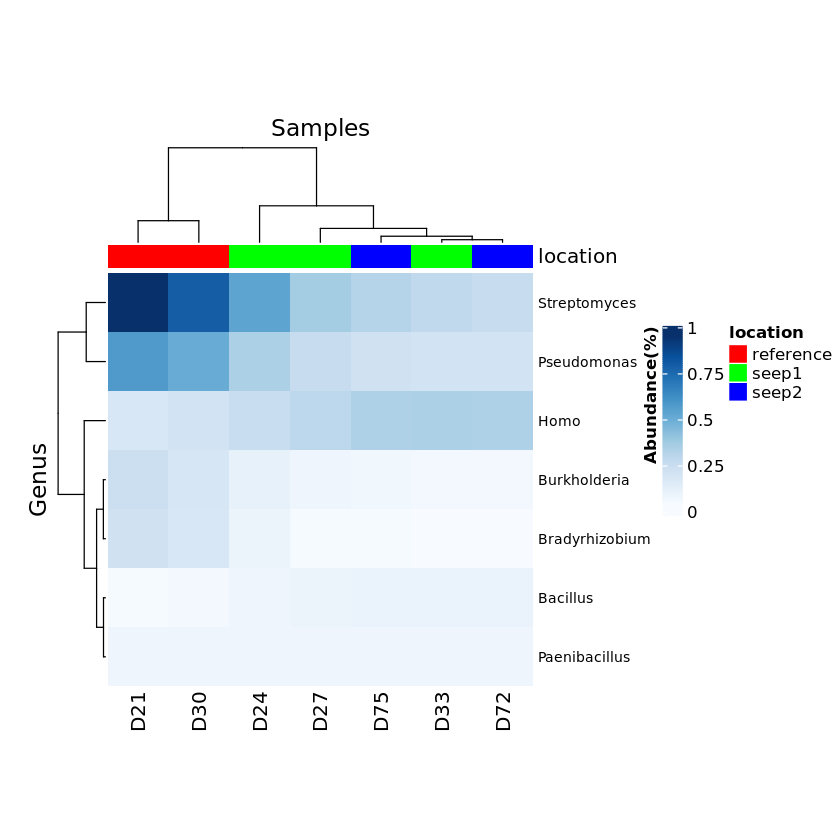

In [1]:
suppressPackageStartupMessages(library(ComplexHeatmap))
library(RColorBrewer)
#most basic heatmap with genus level

genusdata = read.csv("kraken_genus_percent_table.csv", row.names = 1)  # load the data w row names 
#dim(genusdata)

genusdata1 = t(genusdata) #transpose data to have samples in one column and taxa names in first row

matrix = as.matrix(genusdata1)
#row.names(matrix)
#class(my_matrix) #see data type

#total abundances of each phylum in percent
abundances=apply(matrix,2,sum)
#print(abundances)

#highs and lows of abundances 
badd=matrix[,abundances<.6]
goodd=matrix[,abundances>.6]

#dim(goodd)

#sees how many colums will be removed 
#ncol(matrix)-ncol(goodd)
#ncol(badd)

mat = goodd #from previous heatmap - genus percent

#changing rownames
rownames(mat) = c("D75","D30", "D33", "D72","D24","D21","D27")
mat = t(mat)

#making annnotation for location of seeps (column)
ha = HeatmapAnnotation(location = c("seep2", "reference", "seep1", "seep2", "seep1", "reference", "seep1"),
                       col = list(location = c("seep2" = "blue", "reference" = "red", "seep1" = "green")))

#make heatmap
Heatmap(mat,
        name = "abundance(%)", width = unit(9, "cm"), height = unit(8.75, "cm"),
        top_annotation = ha,
        cluster_columns=TRUE, 
        row_dend_side = "left",
        row_names_gp=gpar(cex= .7),
        column_names_gp=gpar(cex= 1),
        row_dend_width = unit(1, "cm"),
        column_dend_height = unit(2,"cm"),
        column_title = "Samples", row_title = "Genus",
        brewer.pal(n=9, name="Blues"),
        heatmap_legend_param = list(
            at = c(0, .25, .5, .75, 1),
            title = "Abundance(%)", 
            legend_height = unit(4, "cm"),
            title_position = "lefttop-rot"
))

#want to put legend horizontal and at bottom 

**Conclusions**

Heatmap (Genus)

Looking at the heatmap above, most abundance comes from the genus Streptomyces in the reference samples.

Looking at the heatmap above, the most abundant genus is Strepomyces in the reference samples. 

From the dendrogram on the horizontal axis, samples D21 and D30 are more similar compared to the other samples. 

The genuses with the most abundance are more similar compared to the other genus.

Most samples have very low abundance in all genus, being less than one percent.

[1] 14157

[1] 14157

                                D75  D30  D33  D72  D24  D21  D27
Rhodopseudomonas palustris     0.01 0.04 0.01 0.01 0.02 0.05 0.01
Sorangium cellulosum           0.03 0.09 0.03 0.03 0.05 0.11 0.04
Desulfoglaeba alkanexedens     0.04 0.02 0.04 0.04 0.02 0.01 0.03
Candidatus Promineofilum breve 0.03 0.02 0.03 0.03 0.02 0.02 0.04
Homo sapiens                   0.34 0.22 0.35 0.34 0.26 0.19 0.30


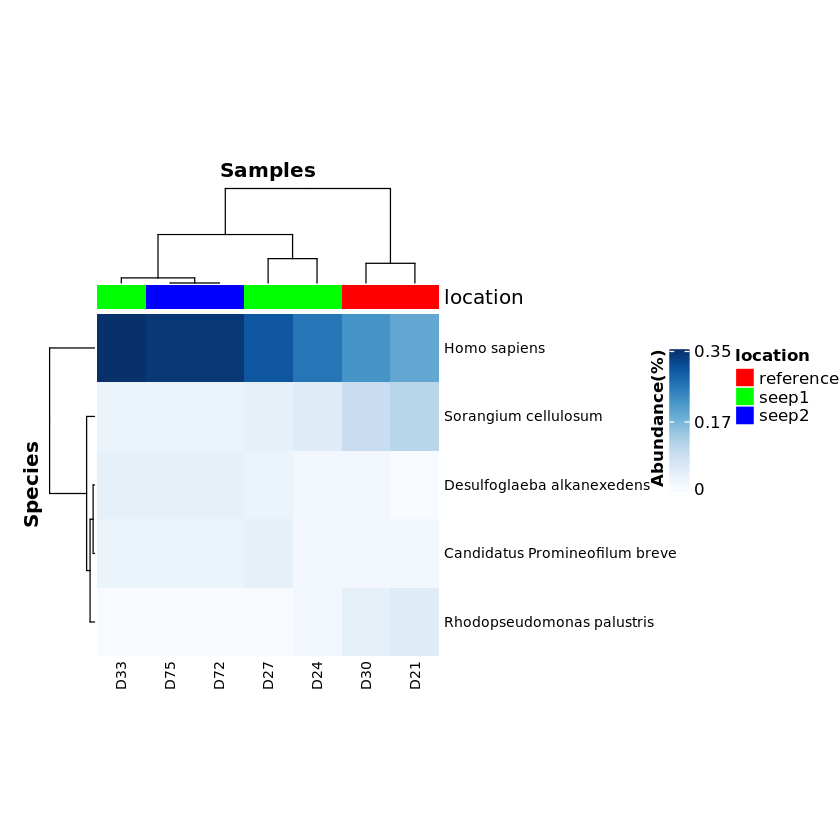

In [4]:
suppressPackageStartupMessages(library(ComplexHeatmap))
library(RColorBrewer)
#taxa species by percent

sd = read.csv("kraken_species_percent_table.csv", row.names = 1)  # load the data w row names 
#dim(sd)

tspecies = t(sd) #transpose data to have samples in one column and taxa names in first row

thematrix = as.matrix(tspecies)

#total abundances of each phylum in percent
speciesabundance=apply(thematrix,2,sum)

#highs and lows of abundances 
noes=thematrix[,speciesabundance<.133]
yeses=thematrix[,speciesabundance>.133]

#sees how many colums will be removed 
ncol(thematrix)-ncol(yeses)
ncol(noes)

#Heatmap(yeses)
mt = yeses #from previous heatmap - species percent


rownames(mt) = c("D75","D30", "D33", "D72","D24","D21","D27")
mts = t(mt)

#making annnotation for location of seeps (column)
ha = HeatmapAnnotation(location = c("seep2", "reference", "seep1", "seep2", "seep1", "reference", "seep1"),
                       col = list(location = c("seep2" = "blue", "reference" = "red", "seep1" = "green")))

Heatmap(mts,
        name = "abundance(%)", width = unit(7.25, "cm"), height = unit(7.25, "cm"),
        top_annotation = ha,
        cluster_columns=TRUE, 
        row_dend_side = "left",
        row_names_gp=gpar(cex= .7),
        column_names_gp=gpar(cex= .7),
        row_dend_width = unit(.95, "cm"),
        column_dend_height = unit(2,"cm"),
        column_title = "Samples", row_title = "Species",
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        row_title_gp = gpar(fontsize = 12, fontface = "bold"),
        brewer.pal(n=9, name="Blues"),
        heatmap_legend_param = list(
            at = c(0, .17, .35),
            title = "Abundance(%)", 
            legend_height = unit(3, "cm"),
            title_position = "lefttop-rot"
))

print(mts)

**Conclusions from heatmap**

Heatmap(Species)

Looking at the heatmap above, Homo sapiens have the most abundant species compared to the other species. This shows that there is human contamination in the sample. It does not make sense for human DNA to be in or near the sediment of hydrocabon seepages in the Gulf of Mexico. This exploratory analysis gives reason to go through a quality control check before doing further anaylsis to remove potential contaimenants that can bias the data. 


** useful reference links I found:**
- Complex Heatmap reference book https://jokergoo.github.io/ComplexHeatmap-reference/book/
- ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3
- Heatmap section using ComplexHeatmap https://marianattestad.com/blog
- plotting using phyloseq and ggplot2 http://joey711.github.io/phyloseq/plot_heatmap-examples (have not tried this)
- different types of heat map packages https://www.datanovia.com/en/lessons/heatmap-in-r-static-and-interactive-visualization/

<br>
<br>

**A simple/fast way to make a heatmap **

**Introduction**

In search of how to improve my heatmap from the stats package, I found someone mention the `levelplot()` from the lattice package. I wanted to try it because unlike `heatmap()` from the stats package, this produces a colorbar. Unforturnately, this plot does not make dendrograms like heatmaps, so this information is lost. The "easiest" way to build a complex heatmap is to update your R (which is easier than you may assume) and install the packages that for complex heatmaps like Bioconductor. 

Using lattice provides a first look on your data and can prepare you for what you will see in your ComplexHeatmap.

More information about using lattice to make heatmaps: https://www.r-graph-gallery.com/27-levelplot-with-lattice.html

**Installations**

- lattice

**Input**

- matrix with taxa as columns, samples are rows, and abundance makes up the matrix (same at heatmap)

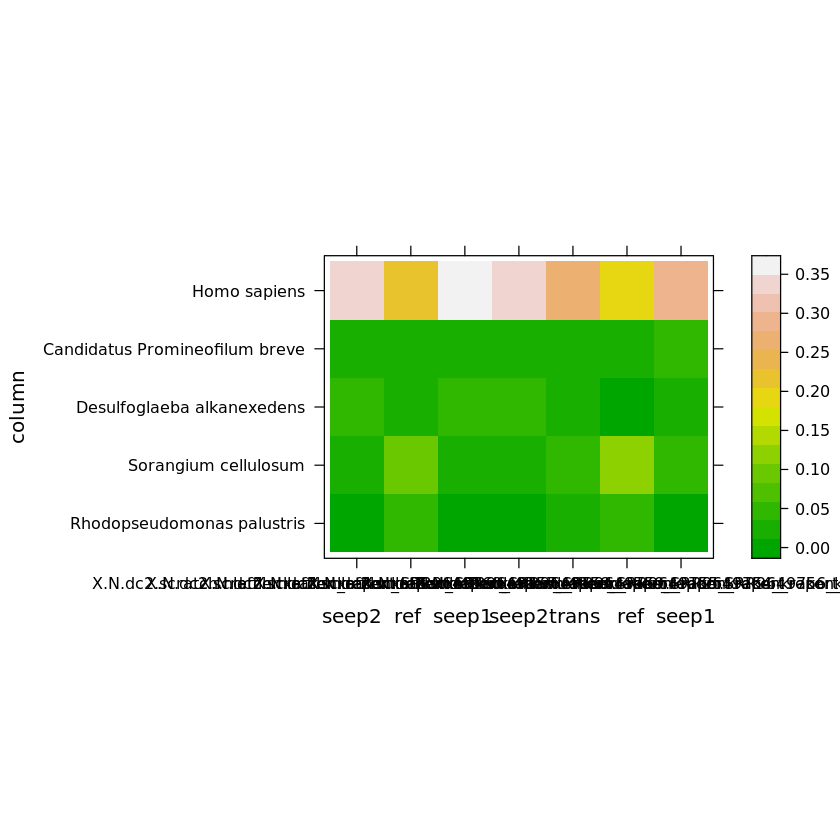

In [21]:
library(lattice)
levelplot(yeses, col.regions = terrain.colors(100),
          xlab = c("seep2","ref","seep1","seep2","trans","ref","seep1"))

This plot is not something to use to draw final conclusions, but rather give an idea of the color range to be expected using a more complex heatmap package. This plot may help you decide whether or not it would be beneficial to include a heatmap in your analysis.